In [194]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import re
#from PIL import Image
from keras.preprocessing import image

In [195]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
base_path = "./Data/garbage_classification/"
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 
            'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
            

In [196]:
len(categories)

12

In [197]:
train = tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=categories,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=50
)
validate=tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=categories,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=50
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [198]:
# model = tf.keras.applications.VGG(
#     include_top=False,
#     input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3),
#     pooling=None,
#     classes=12,
# )

In [199]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       )

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False

model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(keras.layers.Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

In [200]:
model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
#model.build(input_shape=(50,IMAGE_WIDTH,IMAGE_HEIGHT,3))
model.build(input_shape=(50,IMAGE_WIDTH,IMAGE_HEIGHT,3))
model.summary()
early_stop = tf.keras.callbacks.EarlyStopping(patience = 2, verbose = 1, monitor='val_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_7 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 12)                15372     
                                                                 
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [201]:
history = model.fit(train, validation_data=validate, epochs=100, batch_size=50,callbacks=callbacks)

Epoch 1/100
249/249 [==============================] - 25s 89ms/step - loss: 0.9917 - accuracy: 0.7063 - val_loss: 0.6832 - val_accuracy: 0.7908
Epoch 2/100
249/249 [==============================] - 21s 85ms/step - loss: 0.5302 - accuracy: 0.8365 - val_loss: 0.6099 - val_accuracy: 0.8115
Epoch 3/100
249/249 [==============================] - 23s 90ms/step - loss: 0.4108 - accuracy: 0.8750 - val_loss: 0.6021 - val_accuracy: 0.8228
Epoch 4/100
249/249 [==============================] - 22s 89ms/step - loss: 0.3390 - accuracy: 0.8996 - val_loss: 0.6007 - val_accuracy: 0.8215
Epoch 5/100
249/249 [==============================] - 24s 97ms/step - loss: 0.2891 - accuracy: 0.9152 - val_loss: 0.6036 - val_accuracy: 0.8192
Epoch 5: early stopping


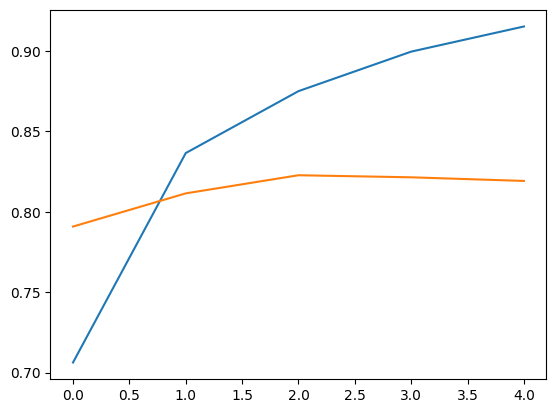

In [202]:
ax = plt.subplot()
ax.plot(history.history["accuracy"], label="Accuracy")
ax.plot(history.history["val_accuracy"], label="Validation Accuracy")

In [203]:
model.save("./Models/Premade-64/")

INFO:tensorflow:Assets written to: ./Models/Premade-64/assets


INFO:tensorflow:Assets written to: ./Models/Premade-64/assets


In [204]:
model.input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_29')>

(64, 64, 3)


ValueError: in user code:

    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(32, 64, 3)


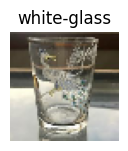

In [205]:
for images, labels in train.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        print(images[i].numpy().shape)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[labels[i]])
        plt.axis("off")
        print(categories[np.argmax(model.predict(images[i].numpy().astype("uint8")))])

Epoch 1/50


2023-02-11 19:11:09.850571: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/ipykernel_12168/1820983278.py", line 1, in <module>
      model.fit(train, validation_data=validate, epochs=50, batch_size=50)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1028, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1122, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/metrics/base_metric.py", line 691, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/metrics/metrics.py", line 3669, in sparse_categorical_accuracy
      matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 970, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
Incompatible shapes: [50] vs. [50,2,2]
	 [[{{node Equal}}]] [Op:__inference_train_function_42767]

In [206]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmpvnvtln_1/assets


INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmpvnvtln_1/assets
2023-02-11 20:48:46.085677: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-11 20:48:46.085694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-11 20:48:46.085815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmpvnvtln_1
2023-02-11 20:48:46.118448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-11 20:48:46.118467: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmpvnvtln_1
2023-02-11 20:48:46.248821: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-11 20:48:46.748453: I tensorflow/cc/saved_model/loader.cc:213] Running initialization